In [22]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import io
from io import StringIO
import os
import subprocess
import sys
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

# LibreOffice conversion using full path on Mac (with check to avoid re-conversion)
filelocation = '/Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Taxes'
filelist = os.listdir(filelocation)
doccollection = []
for files in filelist:
    # Traversing through all the files in the location to find the doc files
    files = os.path.join(filelocation, files)
    doccollection.append(files)

soffice_path = '/Applications/LibreOffice.app/Contents/MacOS/soffice'
if not os.path.exists(soffice_path):
    print("LibreOffice not found. Install it using Homebrew:")
    print("brew install --cask libreoffice")
    print("If you don't have Homebrew, install it from https://brew.sh/")
    print("After installation, restart your terminal and run this script again.")
    sys.exit(1)  # Exit instead of raising error to provide instructions

for x in doccollection:
    if x.endswith('.doc'):
        target_path = x + '.pdf'  # e.g., filename.doc.pdf
        if os.path.exists(target_path):
            print(f"PDF already exists for {x}: {target_path}, skipping conversion.")
            continue

        # Use LibreOffice headless mode to convert .doc to .pdf only if needed
        print(f"Converting {x} to PDF...")
        subprocess.call([soffice_path, '--headless', '--convert-to', 'pdf', x])
        # LibreOffice saves as basename.pdf; rename to match original (basename.doc.pdf)
        pdf_path = os.path.splitext(x)[0] + '.pdf'
        if os.path.exists(pdf_path):
            os.rename(pdf_path, target_path)
            print(f"Converted and renamed to {target_path}")
        else:
            print(f"Conversion failed for {x} - no output PDF found.")

def convert_pdf_to_txt(path):
    """Extract full text from each PDF file in the directory, yielding one full document text per file."""
    filelist = os.listdir(path)
    documentcollection = [os.path.join(path, f) for f in filelist if f.endswith(('.pdf', '.PDF'))]

    for ifiles in documentcollection:
        full_text = ""  # Accumulate text for the entire document
        resource_manager = PDFResourceManager()
        fake_file_handle = io.StringIO()
        converter = TextConverter(resource_manager, fake_file_handle, laparams=LAParams())
        page_interpreter = PDFPageInterpreter(resource_manager, converter)

        with open(ifiles, 'rb') as fh:
            for page in PDFPage.get_pages(fh, caching=True, check_extractable=True):
                page_interpreter.process_page(page)
                # Get accumulated text so far (since converter appends)
                full_text += fake_file_handle.getvalue()
                fake_file_handle.seek(0)  # Reset to read again? Wait, no - better to getvalue after all pages

        # Get the full text after processing all pages
        full_text = fake_file_handle.getvalue()

        # Yield the full document text
        if full_text.strip():  # Only if there's content
            yield full_text

        # Closing open handles
        converter.close()
        fake_file_handle.close()

# Usage
filepath = '/Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Taxes'
textcontents = list(convert_pdf_to_txt(filepath))  # Convert generator to list for DataFrame
dftaxes = pd.DataFrame(textcontents, columns=['Text_Data'])
dftaxes['Category'] = 'Taxes'  # Adding the taxes label

print(f"Processed {len(dftaxes)} PDF files into DataFrame (one row per document).")
print(dftaxes.head())  # Preview the DataFrame

PDF already exists for /Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Taxes/pence-distribution-1996.doc: /Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Taxes/pence-distribution-1996.doc.pdf, skipping conversion.
PDF already exists for /Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Taxes/norwest-tax-1997-10-01.doc: /Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Taxes/norwest-tax-1997-10-01.doc.pdf, skipping conversion.
PDF already exists for /Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Taxes/blackstone-tax-2007.doc: /Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Taxes/blackstone-tax-2007.doc.pdf, skipping conversion.
PDF already exists for /Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Taxes/tax.indemn.2004.09.24.doc: /Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Taxes/tax.indemn.2004.09.24.doc.pdf, skipping co

In [23]:
# import pandas as pd
# def convert_pdf_to_txt(path):
#     #alltexts = []
#     filelist=os.listdir(path)
#     documentcollection=[]
#     for files in filelist:
#         files=os.path.join(path,files)
#         documentcollection.append(files)
#     for ifiles in documentcollection:
#         if ifiles.endswith('.pdf') or ifiles.endswith('.PDF'): #different extensions on the raw data
#             with open(ifiles, 'rb') as fh:
#                 for page in PDFPage.get_pages(fh,
#                                               caching=True,
#                                               check_extractable=True):
#                     resource_manager = PDFResourceManager()
#                     fake_file_handle = io.StringIO()
#                     converter = TextConverter(resource_manager, fake_file_handle)
#                     page_interpreter = PDFPageInterpreter(resource_manager, converter)
#                     page_interpreter.process_page(page)
#
#                     text = fake_file_handle.getvalue() # extraction of the text data
#                     yield text
#
#                     # closing open handles
#                     converter.close()
#                     fake_file_handle.close()
#
#     #return alltexts

In [24]:
# filepath='/Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Taxes'
# textcontents = convert_pdf_to_txt(filepath)
# dftaxes = pd.DataFrame(textcontents, columns = ['Text_Data'])
# dftaxes['Category'] = 'Taxes' # Adding the taxes label

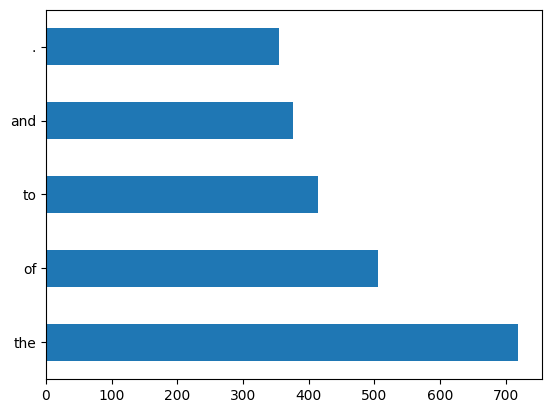

In [25]:
# Plotting 5 most occuring words in the 'Taxes' documents

taxfreq = pd.Series(' '.join(dftaxes['Text_Data']).split()).value_counts()[:5]
taxfreq.plot(kind='barh');
plt.show()

In [27]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data (run this once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Often needed for lemmatization with WordNet

# Pre-processing the extracted textual data
dftaxes['Text_Data'] = dftaxes['Text_Data'].apply(lambda x: " ".join(x.lower() for x in x.split()))  # lower case conversion
dftaxes['Text_Data'] = dftaxes['Text_Data'].str.replace('[^\w\s]','')  # getting rid of special characters
dftaxes['Text_Data'] = dftaxes['Text_Data'].str.replace('\d+', '')  # removing numeric values from between the words
dftaxes['Text_Data'] = dftaxes['Text_Data'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation + string.digits)))  # removing punctuation and digits (combined step)
stop = stopwords.words('english')
dftaxes['Text_Data'] = dftaxes['Text_Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))  # removing stop words
stemmer = WordNetLemmatizer()
dftaxes['Text_Data'] = dftaxes['Text_Data'].apply(lambda x: " ".join(stemmer.lemmatize(word) for word in x.split()))  # converting words to their dictionary form (fixed: apply per document, split/join words)
dftaxes['Text_Data'] = dftaxes['Text_Data'].str.replace('shall', '')  # specific removal

print("Preprocessing complete!")
print(dftaxes['Text_Data'].head())  # Preview processed text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srivenkatreddy/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/srivenkatreddy/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/srivenkatreddy/nltk_data...


Preprocessing complete!
0    signature following page page witness whereof ...
1    sale tax return form instruction continued ann...
2    name title dated ment right obligation party a...
3    page intentionally left blank witness whereof ...
4    partnership promissory note sale service sever...
Name: Text_Data, dtype: object


In [28]:
dftaxes['Identifiers'] = 'tax,agreement,section,group,date'
dftaxes[:5]

,Text_Data,Category,Identifiers
0,signature following page page witness whereof ...,Taxes,"tax,agreement,section,group,date"
1,sale tax return form instruction continued ann...,Taxes,"tax,agreement,section,group,date"
2,name title dated ment right obligation party a...,Taxes,"tax,agreement,section,group,date"
3,page intentionally left blank witness whereof ...,Taxes,"tax,agreement,section,group,date"
4,partnership promissory note sale service sever...,Taxes,"tax,agreement,section,group,date"


### Performing the same tasks on other category folders

In [29]:
filepath='/Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Agreements'
agreementcontents = convert_pdf_to_txt(filepath)
dfagreement = pd.DataFrame(agreementcontents, columns = ['Text_Data']) 
dfagreement['Category'] = 'Agreement'

In [31]:
dfagreement['Text_Data'] = dfagreement['Text_Data'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfagreement['Text_Data'] = dfagreement['Text_Data'].str.replace('[^\w\s]','')
dfagreement['Text_Data'] = dfagreement['Text_Data'].str.replace('\d+', '') # remove numeric values from between the words
dfagreement['Text_Data'] = dfagreement['Text_Data'].apply(lambda x: x.translate(string.digits))
stop = stopwords.words('english')
dfagreement['Text_Data'] = dfagreement['Text_Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
stemmer = WordNetLemmatizer()
dfagreement['Text_Data'] = [stemmer.lemmatize(word) for word in dfagreement['Text_Data']]
dfagreement['Text_Data'] = dfagreement['Text_Data'].str.replace('shall', '')

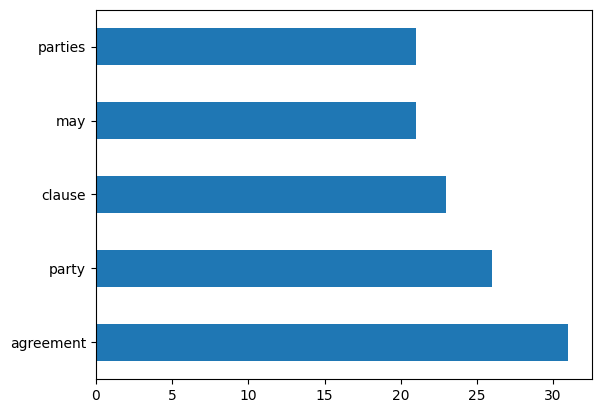

In [32]:
agfreq = pd.Series(' '.join(dfagreement['Text_Data']).split()).value_counts()[:5]
agfreq.plot(kind='barh');
plt.show()

In [33]:
dfagreement['Identifiers'] = 'agreement,subcontractor,contractor,work,subcontract'
dfagreement[:5]

,Text_Data,Category,Identifiers
0,subcontractorpracticename signatures names tit...,Agreement,"agreement,subcontractor,contractor,work,subcon..."
1,"17. settlers defend, indemnify hold harmless c...",Agreement,"agreement,subcontractor,contractor,work,subcon..."
2,master services agreement exhibit b: arista pr...,Agreement,"agreement,subcontractor,contractor,work,subcon..."
3,1 2 3 4 5 6 7 8 9 parties previously reported ...,Agreement,"agreement,subcontractor,contractor,work,subcon..."
4,§ 15.2 payments due unpaid subcontract bear in...,Agreement,"agreement,subcontractor,contractor,work,subcon..."


In [34]:
filepath='/Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Deeds'
deedscontents = convert_pdf_to_txt(filepath)
dfdeeds = pd.DataFrame(deedscontents, columns = ['Text_Data']) 
dfdeeds['Category'] = 'Deeds'

In [35]:
dfdeeds['Text_Data'] = dfdeeds['Text_Data'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfdeeds['Text_Data'] = dfdeeds['Text_Data'].str.replace('[^\w\s]','')
dfdeeds['Text_Data'] = dfdeeds['Text_Data'].str.replace('\d+', '') # remove numeric values from between the words
dfdeeds['Text_Data'] = dfdeeds['Text_Data'].apply(lambda x: x.translate(string.digits))
stop = stopwords.words('english')
dfdeeds['Text_Data'] = dfdeeds['Text_Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
stemmer = WordNetLemmatizer()
dfdeeds['Text_Data'] = [stemmer.lemmatize(word) for word in dfdeeds['Text_Data']]
dfdeeds['Text_Data'] = dfdeeds['Text_Data'].str.replace('shall', '')

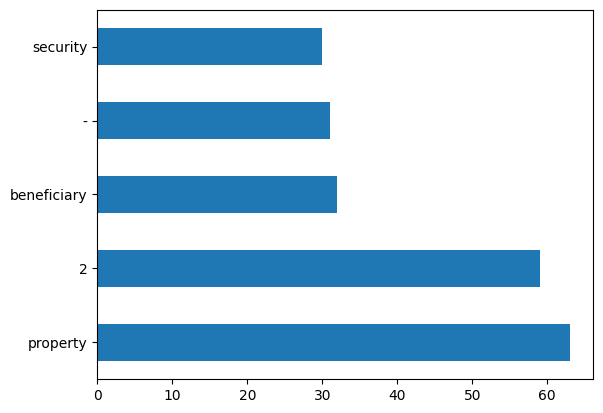

In [36]:
dfreq = pd.Series(' '.join(dfdeeds['Text_Data']).split()).value_counts()[:5]
dfreq.plot(kind='barh');
plt.show()

In [37]:
dfdeeds['Identifiers'] = 'property,borrower,lender,security,beneficiary'
dfdeeds[:5]

,Text_Data,Category,Identifiers
0,25. statement obligation fee. lender may colle...,Deeds,"property,borrower,lender,security,beneficiary"
1,25. statement obligation fee. lender may colle...,Deeds,"property,borrower,lender,security,beneficiary"
2,29. event deed trust foreclosed mortgage prope...,Deeds,"property,borrower,lender,security,beneficiary"
3,2 copy current landlord-tenant handbook move-i...,Deeds,"property,borrower,lender,security,beneficiary"
4,29. event deed trust foreclosed mortgage prope...,Deeds,"property,borrower,lender,security,beneficiary"


In [38]:
filepath='/Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Valuations'
valuationcontents = convert_pdf_to_txt(filepath)
dfvaluation = pd.DataFrame(valuationcontents, columns = ['Text_Data']) 
dfvaluation['Category'] = 'Valuations'

In [39]:
dfvaluation['Text_Data'] = dfvaluation['Text_Data'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfvaluation['Text_Data'] = dfvaluation['Text_Data'].str.replace('[^\w\s]','')
dfvaluation['Text_Data'] = dfvaluation['Text_Data'].str.replace('\d+', '') # remove numeric values from between the words
dfvaluation['Text_Data'] = dfvaluation['Text_Data'].apply(lambda x: x.translate(string.digits))
stop = stopwords.words('english')
stemmer = WordNetLemmatizer()
dfvaluation['Text_Data'] = [stemmer.lemmatize(word) for word in dfvaluation['Text_Data']]
dfvaluation['Text_Data'] = dfvaluation['Text_Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

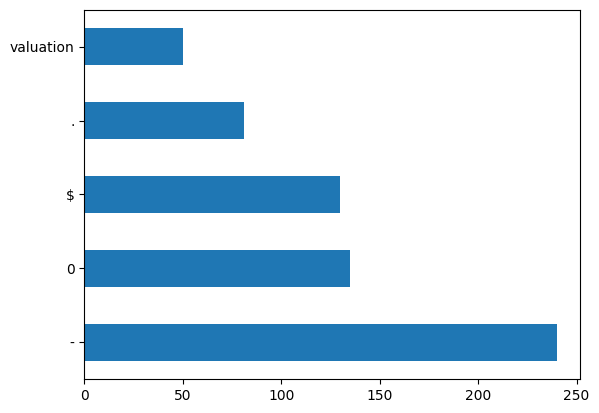

In [40]:
valfreq = pd.Series(' '.join(dfvaluation['Text_Data']).split()).value_counts()[:5]
valfreq.plot(kind='barh');
plt.show()

In [41]:
dfvaluation['Identifiers'] = 'valuation,value,report,market,level'
dfvaluation[:5]

,Text_Data,Category,Identifiers
0,business appraisal review report opinion regar...,Valuations,"valuation,value,report,market,level"
1,architect's estimate costs (this form used pro...,Valuations,"valuation,value,report,market,level"
2,conditions engagement address property (1) pro...,Valuations,"valuation,value,report,market,level"
3,"12-14 northcroft street po box 331-36, takapun...",Valuations,"valuation,value,report,market,level"
4,® 11/15/2010the information opinions presented...,Valuations,"valuation,value,report,market,level"


In [42]:
filepath='/Users/srivenkatreddy/Documents/Projects/Document_classifier/RawData/Human Resources'
hrcontents = convert_pdf_to_txt(filepath)
dfhr = pd.DataFrame(hrcontents, columns = ['Text_Data']) 
dfhr['Category'] = 'Human Resources'

In [43]:
dfhr['Text_Data'] = dfhr['Text_Data'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dfhr['Text_Data'] = dfhr['Text_Data'].str.replace('[^\w\s]','')
dfhr['Text_Data'] = dfhr['Text_Data'].str.replace('\d+', '') # remove numeric values from between the words
dfhr['Text_Data'] = dfhr['Text_Data'].apply(lambda x: x.translate(string.digits))
stop = stopwords.words('english')
dfhr['Text_Data'] = dfhr['Text_Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
stemmer = WordNetLemmatizer()
dfhr['Text_Data'] = [stemmer.lemmatize(word) for word in dfhr['Text_Data']]
dfhr['Text_Data'] = dfhr['Text_Data'].str.replace('may', '')

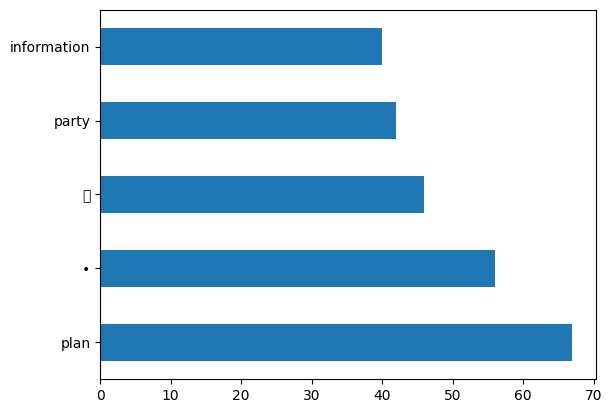

In [44]:
hrfreq = pd.Series(' '.join(dfhr['Text_Data']).split()).value_counts()[:5]
hrfreq.plot(kind='barh');
plt.show()

In [45]:
dfhr['Identifiers'] = 'plan,coverage,benefits,service,level'
dfhr[:5]

,Text_Data,Category,Identifiers
0,person designated employee. die employee witho...,Human Resources,"plan,coverage,benefits,service,level"
1,participating union locals ufcw local 135 san ...,Human Resources,"plan,coverage,benefits,service,level"
2,(cid:131) closes kitchen properly follows clos...,Human Resources,"plan,coverage,benefits,service,level"
3,"apply apply, send cover letter outlining aptit...",Human Resources,"plan,coverage,benefits,service,level"
4,action plans/training development goals (cid:4...,Human Resources,"plan,coverage,benefits,service,level"


In [46]:
frames = [dftaxes, dfagreement, dfdeeds, dfvaluation, dfhr]
finalframe = pd.concat(frames,sort=False)
finalframe = finalframe[['Identifiers','Text_Data','Category']]
finalframe = finalframe.reset_index(drop=True)
finalframe[:5]

,Identifiers,Text_Data,Category
0,"tax,agreement,section,group,date",signature following page page witness whereof ...,Taxes
1,"tax,agreement,section,group,date",sale tax return form instruction continued ann...,Taxes
2,"tax,agreement,section,group,date",name title dated ment right obligation party a...,Taxes
3,"tax,agreement,section,group,date",page intentionally left blank witness whereof ...,Taxes
4,"tax,agreement,section,group,date",partnership promissory note sale service sever...,Taxes


Training data after using TF-IDF. Term Frequency - Inverse document frequency takes care of the assigning vectors to the word based on the frequency of them occuring in each document. 

In [47]:
# Converting the text data into vectors using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.preprocessing import LabelEncoder
# Generating 1000 features for the input for the model
tfidfconverter = TfidfVectorizer(max_features=1000, stop_words=stopwords.words('english')) 
X = pd.DataFrame(tfidfconverter.fit_transform(finalframe['Text_Data']).toarray())
print(X[:5])
#X.columns = range(X.shape[1])
labelencoder = LabelEncoder() #Converting the labels to numeric labels
y = labelencoder.fit_transform(finalframe['Category'])

   0    1    2    3    4    5    6    7    8    9    ...  990       991  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.029663   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.040909   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.064306   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000000   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000000   

        992       993       994  995       996  997  998  999  
0  0.000000  0.000000  0.021759  0.0  0.050883  0.0  0.0  0.0  
1  0.026144  0.000000  0.000000  0.0  0.017544  0.0  0.0  0.0  
2  0.000000  0.000000  0.023585  0.0  0.000000  0.0  0.0  0.0  
3  0.000000  0.033156  0.000000  0.0  0.000000  0.0  0.0  0.0  
4  0.000000  0.062975  0.000000  0.0  0.000000  0.0  0.0  0.0  

[5 rows x 1000 columns]


In [48]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [49]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [50]:
import numpy as np
unique, counts = np.unique(y_resampled, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 0 30]
 [ 1 30]
 [ 2 30]
 [ 3 30]
 [ 4 30]]


In [51]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
classifier = RandomForestClassifier(n_estimators=1200, random_state=1)  #defining 1000 nodes 
rf = classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test) 

Accuracy: 0.9666666666666667
Confusion matrix:
 [[7 0 0 0 0]
 [0 5 0 0 0]
 [0 0 7 0 0]
 [0 0 0 6 0]
 [0 0 1 0 4]]


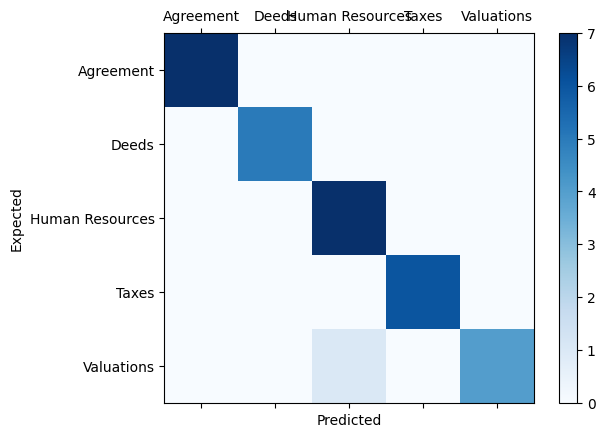

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('Accuracy: %s' % accuracy_score(y_test, y_pred))
# print(classification_report(y_test,y_pred,target_names=my_tags))
#print(confusion_matrix(y_test,y_pred)) 

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Agreement', 'Deeds','Human Resources','Taxes','Valuations']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [54]:
# Saving model to disk
import pickle
import requests
import json
pickle.dump(rf, open('rfmodel.pkl','wb'))

Accuracy: 1.0
Confusion matrix:
 [[7 0 0 0 0]
 [0 5 0 0 0]
 [0 0 7 0 0]
 [0 0 0 6 0]
 [0 0 0 0 5]]


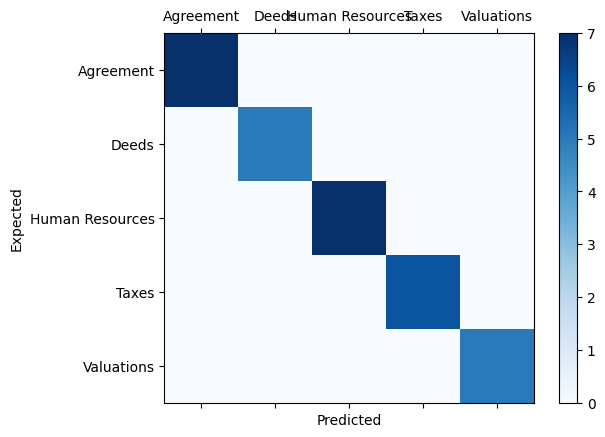

In [55]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred,target_names=my_tags))

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Agreement', 'Deeds','Human Resources','Taxes','Valuations']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [56]:
pickle.dump(clf, open('nbmodel.pkl','wb'))

Accuracy: 0.9333333333333333
Confusion matrix:
 [[7 0 0 0 0]
 [0 5 0 0 0]
 [0 0 7 0 0]
 [0 1 0 4 1]
 [0 0 0 0 5]]


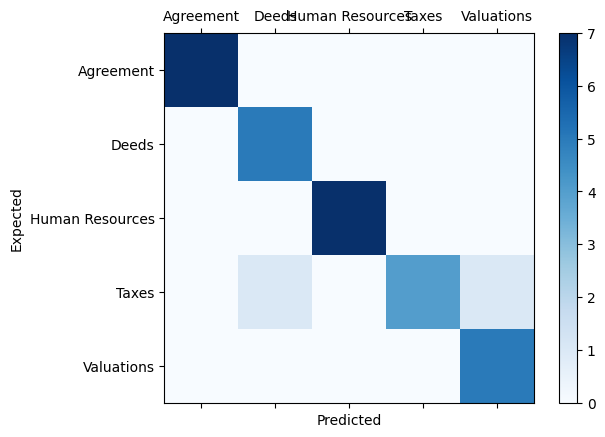

In [58]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %s" % (accuracy))
# print(classification_report(y_test, y_pred,target_names=my_tags))

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Agreement', 'Deeds','Human Resources','Taxes','Valuations']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [59]:
pickle.dump(xgb, open('xgbmodel.pkl','wb'))

In [60]:
#Loading the saved model and a random PDF file to test classification
savedmodel = pickle.load(open('nbmodel.pkl','rb'))
demofile = 'test_taxes.pdf'

In [64]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

# Assuming demofile is defined, e.g., demofile = 'path/to/your/file.pdf'

def convert2txt():
    alltexts = []
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)  # Removed codec=codec
    with open(demofile, 'rb') as fp:  # Use with open for proper handling
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        password = ""
        maxpages = 0
        caching = True
        pagenos = set()

        for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching, check_extractable=True):
            interpreter.process_page(page)

        text = retstr.getvalue()
        alltexts.append(text)
        device.close()
        retstr.close()

    return alltexts

textdata = convert2txt()
print("Text extraction complete!")
print(textdata[0][:500])  # Preview first 500 chars

Text extraction complete!
                             TAX INDEMNITY AGREEMENT 
 
      THIS TAX INDEMNITY AGREEMENT (this "AGREEMENT"), dated November 29, 200
4, 
is entered into by and among Focus Media Holding Limited, an international 
business company organized under the laws of the British Virgin Islands (the 
"COMPANY"), GS Focus Holding Limited, an exempted company organized and exist
ing 
under the laws of the Cayman Islands (the "LEAD INVESTOR"), 3i Group plc, a 
company organized and existing under the laws of


In [65]:
# Feature engineering to get the data in right format
dfdemo = pd.DataFrame(textdata, columns = ['Data'])
dfdemo['Data'] = dfdemo['Data'].apply(lambda x: " ".join(x.lower() for x in x.split())) # lower case conversion
dfdemo['Data'] = dfdemo['Data'].str.replace('[^\w\s]','') # getting rid of special characters
dfdemo['Data'] = dfdemo['Data'].str.replace('\d+', '') # removing numeric values from between the words
dfdemo['Data'] = dfdemo['Data'].apply(lambda x: x.translate(string.digits)) # removing numerical numbers
stop = stopwords.words('english')
dfdemo['Data'] = dfdemo['Data'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #removing stop words
stemmer = WordNetLemmatizer()
dfdemo['Data'] = [stemmer.lemmatize(word) for word in dfdemo['Data']]

In [67]:
# Assigning vectors to the input data
tfidfconverter = TfidfVectorizer(max_features=1000, stop_words=stopwords.words('english'))
inputs = pd.DataFrame(tfidfconverter.fit_transform(dfdemo['Data']).toarray())
inputs

,0,1,2,3,4,5,6,7,8,9,...,988,989,990,991,992,993,994,995,996,997
0,0.011861,0.017791,0.00593,0.017791,0.011861,0.00593,0.00593,0.00593,0.011861,0.00593,...,0.011861,0.011861,0.017791,0.029652,0.035583,0.00593,0.023722,0.017791,0.00593,0.011861


In [72]:
# CODE TO ADD IN NOTEBOOK
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import pandas as pd

# Recreate the objects and fit them to the finalframe data
# NOTE: The TfidfVectorizer was already fit in Execution Count 47,
# but refitting here ensures we save the version with the correct feature set (max_features=1000).
tfidfconverter_save = TfidfVectorizer(max_features=1000, stop_words=stopwords.words('english'))
tfidfconverter_save.fit(finalframe['Text_Data']) # Fit on the 'Text_Data'
labelencoder_save = LabelEncoder()
labelencoder_save.fit(finalframe['Category']) # Fit on the 'Category'

# Save the necessary objects
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidfconverter_save, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(labelencoder_save, f)

print("TfidfVectorizer and LabelEncoder saved to tfidf.pkl and label_encoder.pkl")

TfidfVectorizer and LabelEncoder saved to tfidf.pkl and label_encoder.pkl


In [68]:
# Predicting the category of the input file with the help of trained model

output_category = savedmodel.predict(inputs)
#Comment the next line if you are testing word2vec model as it doesn't require transformation
output_category = (labelencoder.inverse_transform((output_category)))
output_category

ValueError: X has 998 features, but MultinomialNB is expecting 1000 features as input.

## Conclusion

The saved model has correctly predicted the class of the input file. The saved model was Naive Bayes Classifier which had predicting accuracy of around 93% with a good precision for all classes above 90%. 
Different classification models can be trained for this task and comapred for their perfomances. 